# Question 3: Data Pipeline and Transformation

Objective:
- Show understanding of creating data pipelines and transformations.

Task:
- Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021.
- Calculate MACD (slow/medium/fast) and RSI for each metal historically.
- Use SQL inserts to populate the SQL table created in Question 2 with this generated data.
- Demonstrate the use of a decorator to log the execution of the SQL inserts.

In [33]:
import os
from datetime import timedelta
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = f'{os.pardir}/data/MarketData.csv'

In [2]:
# Load the data 
raw_df = pd.read_csv(data_path)
raw_df

,Start Date,01/01/2010,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,End Date,01/01/2023,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,LME COPPER 3MO ($),LME ALUMINUM 3MO ($),LME ZINC 3MO ($),LME LEAD 3MO ($),LME TIN 3MO ($),Generic 1st 'CL' Future
3,NaN,LMCADS03 Comdty,LMAHDS03 Comdty,LMZSDS03 Comdty,LMPBDS03 Comdty,LMSNDS03 Comdty,CL1 Comdty
4,NaN,Settlement Price,Settlement Price,Settlement Price,Settlement Price,Settlement Price,Settlement Price
...,...,...,...,...,...,...,...
3392,26/12/2022,8349.5,2389.5,2965,2273.5,23934,79.56
3393,27/12/2022,8349.5,2389.5,2965,2273.5,23934,79.53
3394,28/12/2022,8443,2381,3005.5,2218,24734,78.96
3395,29/12/2022,8418,2405,2984.5,2272.5,24915,78.4


In [3]:
# Select only Dates, Copper, and Zinc columns, the first 6 rows are other information
df = raw_df.iloc[6:, [0,1,3]].copy() # TODO: do this by using the column names
df.columns = ['Dates', 'Copper', 'Zinc']
# Ensure the data types are correct
df['Dates'] = pd.to_datetime(df['Dates'], format='%d/%m/%Y', errors='coerce')
df['Copper'] = pd.to_numeric(df['Copper'], errors='coerce')
df['Zinc'] = pd.to_numeric(df['Zinc'], errors='coerce')
print(df.isna().sum())
df

Dates     0
Copper    0
Zinc      0
dtype: int64


,Dates,Copper,Zinc
6,2010-01-01,7375.0,2560.0
7,2010-01-04,7500.0,2574.0
8,2010-01-05,7485.0,2575.0
9,2010-01-06,7660.0,2718.0
10,2010-01-07,7535.0,2607.0
...,...,...,...
3392,2022-12-26,8349.5,2965.0
3393,2022-12-27,8349.5,2965.0
3394,2022-12-28,8443.0,3005.5
3395,2022-12-29,8418.0,2984.5


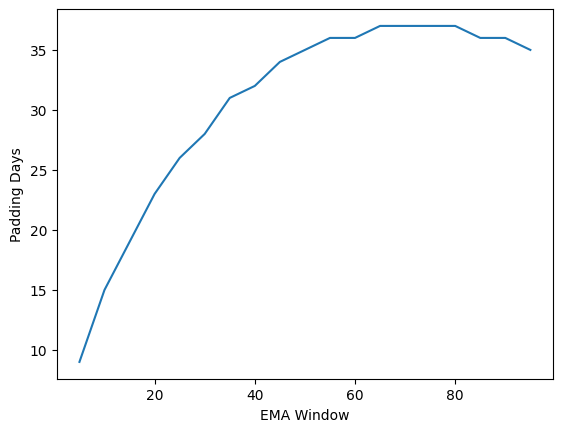

In [4]:
# Calculate how many days of padding I need to calculate an accurate EMA
precision = 0.01 # Weight smaller than 5%
paddings = []
for ema_window in np.arange(5, 100, 5):
    N_padding = int(np.ceil(np.log((ema_window + 1) * (precision / 2)) / np.log((ema_window - 1) / (ema_window + 1))))
    paddings.append(N_padding)

plt.plot(np.arange(5, 100, 5), paddings)
plt.xlabel('EMA Window')
plt.ylabel('Padding Days')
plt.show()

In [5]:
# # Select only 2020 and 2021 with a padding at the beginning
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
# Use a padding to calculate the EMA and RSI without a starting bias
padding = 40
cutoff_date = start_date - timedelta(days=padding)
df = df[(df['Dates'] > cutoff_date) & (df['Dates'] < end_date)]
df

,Dates,Copper,Zinc
2587,2019-11-25,5868.0,2281.0
2588,2019-11-26,5924.0,2299.0
2589,2019-11-27,5945.0,2297.0
2590,2019-11-28,5892.0,2278.0
2591,2019-11-29,5864.0,2273.5
...,...,...,...
3131,2021-12-24,9568.0,3519.0
3132,2021-12-27,9568.0,3519.0
3133,2021-12-28,9568.0,3519.0
3134,2021-12-29,9680.5,3513.0


In [31]:
# Calculate the MACD for Copper and Zinc

def calculate_MACD(time_data, short_window=12, long_window=26):
    """Calculate the Moving Average Convergence Divergence (MACD) for a given time series.
    INPUTS:
    - data: pd.Series, the time series data 
    - short_window, long_window: int, the short and long window periods for MACD line (EMA_short - EMA_long).
    OUTPUTS:
    - macd: pd.Series, as per definition
    """
    short_EMA = time_data.ewm(span=short_window, adjust=False).mean()
    long_EMA = time_data.ewm(span=long_window, adjust=False).mean()
    return short_EMA - long_EMA

def calculate_RSI(time_data, window=14):
    """Calculate the Relative Strength Index (RSI) for a given time series.
    INPUTS:
    - data: pd.Series, the time series data 
    - window: int, the window period for RSI
    OUTPUTS:
    - rsi: pd.Series, as per definition
    """
    delta = time_data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0) 
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    # Avoid division by zero
    rs = avg_gain / avg_loss.replace(to_replace=0, value=10e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

macd_copper = calculate_MACD(df['Copper'])
rsi_copper = calculate_RSI(df['Copper'])